In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.image import preprocess_image
import kagglehub

In [8]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("apollo2506/landuse-scene-classification")
data_path = os.path.join(path, "images_train_test_val")

100%|██████████| 1.98G/1.98G [00:26<00:00, 81.9MB/s]

Extracting files...


In [9]:
class ResNet18Model(nn.Module):
    def __init__(self, num_classes=21):
        super(ResNet18Model, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [11]:
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Model(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {correct/len(train_dataset)}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Epoch 1/10, Loss: 0.8737209570148717, Accuracy: 0.731156462585034
Epoch 2/10, Loss: 0.4006488785471605, Accuracy: 0.8774149659863946
Epoch 3/10, Loss: 0.25784332245264363, Accuracy: 0.9183673469387755
Epoch 4/10, Loss: 0.20569537218822084, Accuracy: 0.9359183673469388
Epoch 5/10, Loss: 0.17642062509270465, Accuracy: 0.9443537414965987
Epoch 6/10, Loss: 0.12527459820165582, Accuracy: 0.9617687074829931
Epoch 7/10, Loss: 0.0909979405944519, Accuracy: 0.972108843537415
Epoch 8/10, Loss: 0.11100036066592388, Accuracy: 0.9631292517006803
Epoch 9/10, Loss: 0.10148445885911908, Accuracy: 0.9668027210884353
Epoch 10/10, Loss: 0.07409812706274628, Accuracy: 0.9775510204081632


In [13]:
# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
print(f"Test Accuracy: {correct/total * 100:.2f}%")

# Grad-CAM & Score-CAM Visualization
model.eval()
target_layer = model.model.layer4[1]

Test Accuracy: 93.43%


In [38]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to match model input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

def visualize_cam(image_path, method='gradcam'):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Failed to load image at {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB
    image = cv2.resize(image, (224, 224))  # Resize input image to match model input size
    image_pil = Image.fromarray(image)  # Convert NumPy array to PIL Image
    image_tensor = transform(image_pil).unsqueeze(0).to(device)  # Apply transformations

    # Select GradCAM or ScoreCAM
    cam_algorithm = GradCAM if method == 'gradcam' else ScoreCAM

    # ✅ Corrected: Use ResNet’s last convolutional layer
    target_layer = model.model.layer4[-1]  # Accessing layer4 inside 'model'

    # Initialize CAM
    cam = cam_algorithm(model=model, target_layers=[target_layer])

    # Generate heatmap
    grayscale_cam = cam(input_tensor=image_tensor)[0]
    heatmap = show_cam_on_image(image.astype(np.float32) / 255, grayscale_cam, use_rgb=True)

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title(method.upper())
    plt.show()

    # Release resources
    del cam

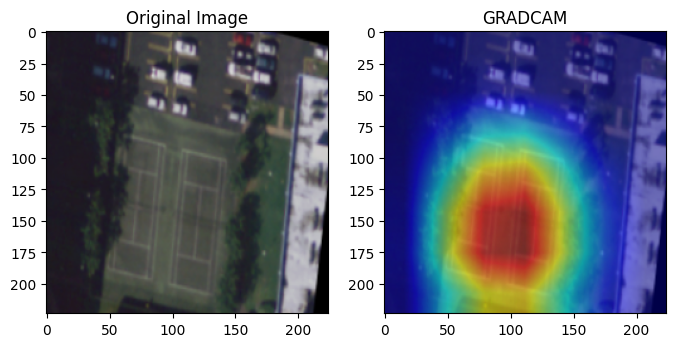

100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


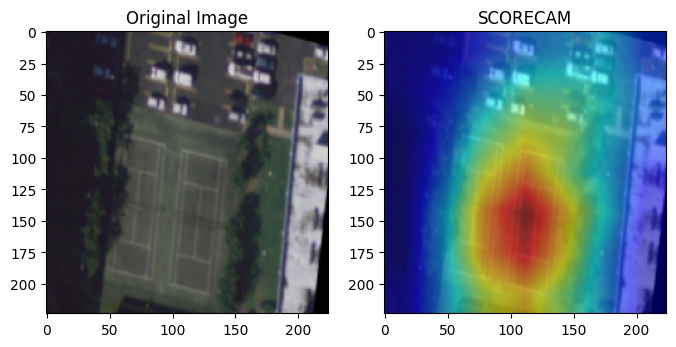

In [39]:
sample_image_path = os.path.join(train_path, 'tenniscourt', 'tenniscourt_000001.png')
visualize_cam(sample_image_path, method='gradcam')
visualize_cam(sample_image_path, method='scorecam')

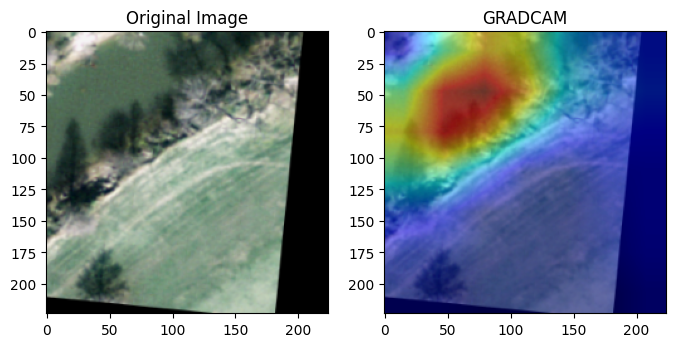

100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


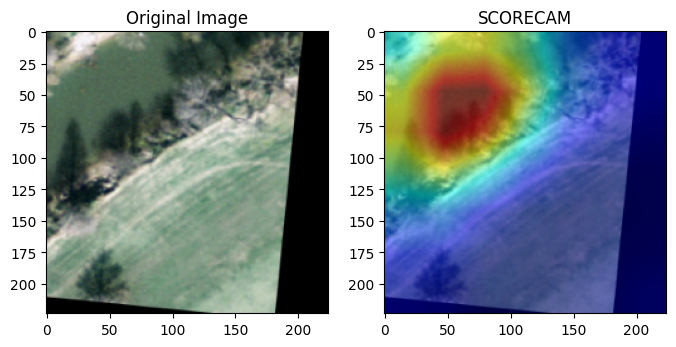

In [40]:
sample_image_path = os.path.join(train_path, 'river', 'river_000011.png')
visualize_cam(sample_image_path, method='gradcam')
visualize_cam(sample_image_path, method='scorecam')